This is early experimenting with importing real world data, playing around with our existing code, and determining how/if h5py (HDF5) file format will be appropriate for our needs.

In [28]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ramannoodles import spectrafit

In [29]:
CO_data = pd.read_excel('../../Baseline Subtracted Data/CarbonMonoxide_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
Me_data = pd.read_excel('../../Baseline Subtracted Data/Methane_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
H_data = pd.read_excel('../../Baseline Subtracted Data/Hydrogen_Baseline_Calibration.xlsx',
                        header=None, names=('x', 'y'))
FA_data = pd.read_excel('../../FormicAcid_3percentconc_400C_5s_00000.xlsx',
                        header=None, names=('x', 'y'))

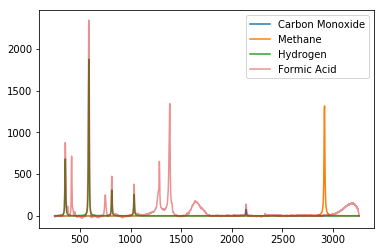

In [30]:
plt.plot(CO_data['x'], CO_data['y'], label='Carbon Monoxide')
plt.plot(Me_data['x'], Me_data['y'], label='Methane')
plt.plot(H_data['x'], H_data['y'], label='Hydrogen')
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid', alpha = 0.5)
plt.legend()

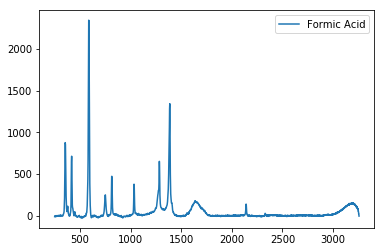

In [31]:
plt.plot(FA_data['x'], FA_data['y'], label='Formic Acid')
plt.legend()

In [32]:
data = H_data

In [33]:
peaks, peak_list1 = spectrafit.peak_detect(data['x'].values, data['y'].values, height=10, prominence=20)
peaks

[(355.6504104104104, 682.2117661687759),
 (587.3333133133133, 1877.5935473330196),
 (816.0073473473473, 309.10228007461126),
 (1035.6547747747748, 256.8016351111647)]

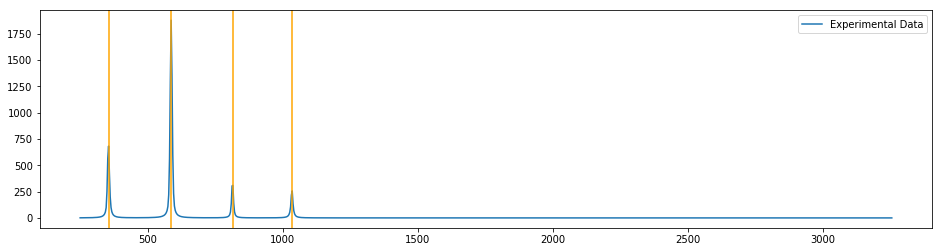

In [34]:
plt.figure(figsize=(16,4))
plt.plot(data['x'], data['y'], label='Experimental Data')
for i in peak_list1[0]:
    plt.axvline(x=data['x'][i], color='orange')
plt.legend()

In [35]:
from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel
from lmfit.models import VoigtModel
from lmfit.models import PseudoVoigtModel

In [36]:
peak_list = []
for i, _ in enumerate(peaks):
    prefix = 'p{}_'.format(i+1)
    peak = PseudoVoigtModel(prefix=prefix)
    if i == 0:
        pars = peak.make_params()
    else:
        pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks[i][0], vary=False,
                              min=(peaks[i][0]-10), max=(peaks[i][0]+10))
    pars[prefix+'height'].set(peaks[i][1], vary=False)
    pars[prefix+'sigma'].set(50, min=0, max=500)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    if i == 0:
        mod = peak_list[i]
    else:
        mod = mod + peak_list[i]

In [37]:
out = mod.fit(data['y'], pars, x=data['x'])
print(out.fit_report())

[[Model]]
    (((Model(pvoigt, prefix='p1_') + Model(pvoigt, prefix='p2_')) + Model(pvoigt, prefix='p3_')) + Model(pvoigt, prefix='p4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 739
    # data points      = 1000
    # variables        = 12
    chi-square         = 36094.1489
    reduced chi-square = 36.5325394
    Akaike info crit   = 3610.13077
    Bayesian info crit = 3669.02384
[[Variables]]
    p1_fraction:   0.68821684 +/- 0.02998040 (4.36%) (init = 0.5)
    p1_sigma:      4.53045639 +/- 0.05709472 (1.26%) (init = 50)
    p1_center:     355.6504 (fixed)
    p1_amplitude:  8518.11804 +/- 92.5906520 (1.09%) (init = 1)
    p1_fwhm:       9.06091278 +/- 0.11418945 (1.26%) == '2.0000000*p1_sigma'
    p1_height:     682.2118 (fixed)
    p2_fraction:   0.57368567 +/- 0.01186410 (2.07%) (init = 0.5)
    p2_sigma:      4.40829455 +/- 0.01933399 (0.44%) (init = 50)
    p2_center:     587.3333 (fixed)
    p2_amplitude:  21616.9396 +/- 91.4135279 (0.42%) (

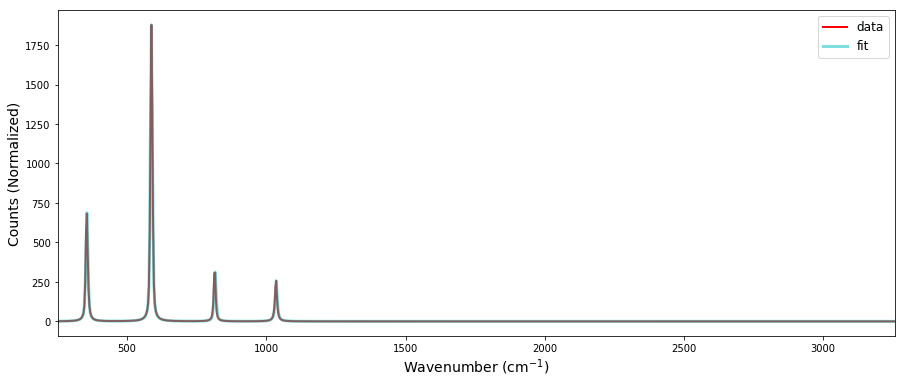

In [38]:
spectrafit.plot_fit(data['x'].values, data['y'].values, out, plot_components=False)

Using our existing code with the baselined single compound data the curve fitting appears to work well. Expecially when a Voigt or Pseudo-Voigt model is used opposed to the Lorentzian. Next we begin to experiment with h5py (HDF5 file format) for storing the data and the result of the curve fitting for future comparison with multi-compound spectra.

In [39]:
f = h5py.File("Hydrogen_test.hdf5", "w")

In [40]:
f['data/x'] = H_data['x']

In [41]:
f['data/y'] = H_data['y']
f['compound'] = 'Hydrogren'

In [42]:
list(f.keys())

['compound', 'data']

In [43]:
x_data = f['data/x'][:]

In [44]:
H_fit = spectrafit.export_fit_data(out)

In [45]:
H_fit

[array([4.53045639e+00, 3.55650410e+02, 8.51811804e+03, 9.06091278e+00,
        6.82211766e+02]),
 array([4.40829455e+00, 5.87333313e+02, 2.16169396e+04, 8.81658910e+00,
        1.87759355e+03]),
 array([   4.4335706 ,  816.00734735, 3749.22428081,    8.8671412 ,
         309.10228007]),
 array([   4.37953992, 1035.65477477, 3413.2385818 ,    8.75907985,
         256.80163511])]

In [46]:
list(f['data'].keys())

['x', 'y']

In [47]:
for i, _ in enumerate(H_fit):
    f['peak/{}'.format(i+1)] = H_fit[i]

In [49]:
list(f['peak/1'])

[4.5304563899437875,
 355.6504104104104,
 8518.118035511281,
 9.060912779887575,
 682.2117661687759]